# Density Estimation (Online Autoregressive Modeling)

## Motivation / Hypothesis
We model MNIST as an autoregressive density estimation problem by **predicting the next pixel given previous pixels**. 

## Experimental Setup
- **Dataset:** MNIST  
- **Training stream:** 5,000 images  
- **Test set:** 200 images  
- **Online (single-pass) learning:** each training image is used **once** and never revisited (no replay / no shuffling-based multi-epoch training).  
- **Preprocessing variants:**
  - **Deterministic binarization:** fixed thresholding
  - **Stochastic binarization:** probabilistic binarization per pixel

## Results (Test NLL in nats per image)
1. **Online PL-MLP (Prospective Learning)**
   - Deterministic: ~70 nats
   - Stochastic: ~76 nats
   - Runtime (train + periodic evaluation): ~4 min

2. **Online Transformer**
   - Deterministic: ~71 nats
   - Stochastic: ~76 nats
   - Runtime (train + periodic evaluation): ~12 min

3. **Online GLN**
   - Deterministic: ~127 nats
   - Stochastic: ~130 nats
   - Runtime (train + periodic evaluation): ~60 min

## Next Steps
1. Debug GLN under both binarization settings, as a strong reference point is around **~79 nats/image** in comparable settings.
2. Setting with **continuous-valued** observations

In [53]:
import math
import os
from dataclasses import dataclass
from typing import Optional
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torchvision.utils as vutils

import xgboost as xgb
from xgboost import XGBClassifier

import wandb

## 1. Data Loading and Preprocessing

In [54]:
class ThresholdBinarizeAndFlatten:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    def __call__(self, x):
        x = (x > self.threshold).float()
        return x.view(-1)

class StochasticBinarizeAndFlatten:
    def __call__(self, x):
        x = torch.bernoulli(x)  # Bernoulli(pixel_intensity)
        return x.view(-1)

def load_mnist_numpy(
    n_train: int,
    n_test: int,
    type_of_cutoff: str = "deterministic",
    data_dir: str = ".././data",
    seed: int = 0,
):
    """
    Load MNIST, apply binarization+flatten transform, and return random subsets as numpy arrays.

    Args:
        n_train: number of training samples to subsample.
        n_test:  number of test samples to subsample.
        type_of_cutoff: "deterministic" or "stochastic" for the TRAIN transform.
                        Test transform is always deterministic ThresholdBinarizeAndFlatten.
        data_dir: where to download/store MNIST.
        seed: RNG seed for subsampling.

    Returns:
        X_train, y_train, X_test, y_test as numpy arrays.
    """
    type_of_cutoff = type_of_cutoff.lower().strip()
    if type_of_cutoff not in {"deterministic", "stochastic"}:
        raise ValueError("type_of_cutoff must be 'deterministic' or 'stochastic'")

    # Train transform: choose deterministic vs stochastic
    train_binarizer = (
        ThresholdBinarizeAndFlatten()
        if type_of_cutoff == "deterministic"
        else StochasticBinarizeAndFlatten()
    )

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        train_binarizer,
    ])

    # Test transform: always deterministic threshold (fixed)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        ThresholdBinarizeAndFlatten(),
    ])

    train_ds = datasets.MNIST(data_dir, train=True, download=True, transform=train_transform)
    test_ds  = datasets.MNIST(data_dir, train=False, download=True, transform=test_transform)

    def ds_to_numpy(ds):
        X = np.empty((len(ds), 784), dtype=np.float32)
        for i in range(len(ds)):
            X[i] = ds[i][0].numpy()
        return X

    X_train_full = ds_to_numpy(train_ds)
    X_test_full  = ds_to_numpy(test_ds)
    y_train_full = train_ds.targets.cpu().numpy()
    y_test_full  = test_ds.targets.cpu().numpy()

    if n_train > X_train_full.shape[0]:
        raise ValueError(f"n_train ({n_train}) > train set size ({X_train_full.shape[0]})")
    if n_test > X_test_full.shape[0]:
        raise ValueError(f"n_test ({n_test}) > test set size ({X_test_full.shape[0]})")

    rng = np.random.default_rng(seed)
    train_idx = rng.choice(X_train_full.shape[0], size=n_train, replace=False)
    test_idx  = rng.choice(X_test_full.shape[0],  size=n_test,  replace=False)

    X_train = X_train_full[train_idx]
    y_train = y_train_full[train_idx]
    X_test  = X_test_full[test_idx]
    y_test  = y_test_full[test_idx]

    return X_train, y_train, X_test, y_test

In [55]:
def time_embedding_np(t, tdim=50):
    freqs = (2 * np.pi) / np.arange(2, tdim + 1, 2)  # (tdim//2,)
    angles = np.outer(np.atleast_1d(t).astype(np.float32), freqs.astype(np.float32))
    sin_emb = np.sin(angles)
    cos_emb = np.cos(angles)
    emb = np.concatenate([sin_emb, cos_emb], axis=-1).astype(np.float32)  # (len(t), tdim)
    if emb.shape[0] == 1:
        return emb[0]
    return emb

In [56]:
seed = 9515
n_train = 5000
n_test = 200
rng = np.random.default_rng(seed)

## 2. Model


### 1. Prospective Learning MLP with Adam

In [57]:
def build_autoreg_rows_single(xi: np.ndarray, max_t=784, tdim=100):
    """
    xi: (784,) binary {0,1}
    Returns:
      F: (max_t, tdim + 784)
      y: (max_t,)
    Exactly matches your build_autoreg_dataset() for N=1.
    """
    xi = xi.astype(np.float32).reshape(-1)
    D = xi.shape[0]
    T = min(max_t, D)

    F = np.zeros((T, tdim + D), dtype=np.float32)
    y = np.zeros((T,), dtype=np.float32)

    for t in range(T):
        time_emb = time_embedding_np(t, tdim=tdim).astype(np.float32)

        known = np.full(D, -1.0, dtype=np.float32)
        if t > 0:
            known[:t] = xi[:t][::-1]  # reverse past pixels

        F[t, :tdim] = time_emb
        F[t, tdim:tdim + D] = known
        y[t] = xi[t]

    return F, y



In [58]:
class AutoregMLP(nn.Module):
    def __init__(self, input_dim: int, hidden: int = 512, depth: int = 6, dropout: float = 0.1):
        """
        depth = number of hidden Linear layers (all width = hidden)
        Architecture: [input -> hidden] + (depth-1)*[hidden -> hidden] + [hidden -> 1]
        """
        super().__init__()
        layers = []
        d = input_dim

        for i in range(depth):
            layers += [nn.Linear(d, hidden), nn.ReLU(), nn.Dropout(dropout)]
            d = hidden

        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

def count_params(model):
    return sum(p.numel() for p in model.parameters())


In [67]:
class OnlineNNConfig:
    lr: float = 1e-4
    weight_decay: float = 1e-5
    steps_per_image: int = 1      # how many passes over the 784 rows per image
    batch_size: int = 256
    clip_grad: Optional[float] = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class OnlineAutoregNN:
    """
    Online trainer for your autoregressive feature formulation:
      - partial_fit_image(xi): xi is (784,) -> builds 784 rows -> Adam update
      - predict_proba_rows(F_rows): proba for rows (like xgb predict_proba)
    """
    def __init__(self, tdim: int = 100, max_t: int = 784, hidden: int = 1024, dropout: float = 0.0,
                 cfg: Optional[OnlineNNConfig] = None):
        self.tdim = tdim
        self.max_t = max_t
        self.cfg = cfg or OnlineNNConfig()

        self.input_dim = tdim + 784
        self.model = AutoregMLP(self.input_dim, hidden=hidden, depth=3, dropout=dropout).to(self.cfg.device)
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)

    def fit_init(self, X_init: np.ndarray, steps: int = 1) -> "OnlineAutoregNN":
        """
        Optional warm-start on a small set of images (still no replay during streaming).
        X_init: (N,784)
        """
        for _ in range(steps):
            for i in range(X_init.shape[0]):
                self.partial_fit_image(X_init[i])
        return self

    def partial_fit_image(self, xi: np.ndarray) -> float:
        """
        One online step on a single image.
        Returns mean loss over the image.
        """
        F_rows, y_rows = build_autoreg_rows_single(xi, max_t=self.max_t, tdim=self.tdim)

        X = torch.from_numpy(F_rows).to(self.cfg.device)
        y = torch.from_numpy(y_rows).to(self.cfg.device)

        self.model.train()
        n = X.shape[0]
        # bs = min(self.cfg.batch_size, n)
        bs = n

        total_loss = 0.0
        for _ in range(self.cfg.steps_per_image):
            # perm = torch.randperm(n, device=self.cfg.device)
            for j in range(0, n, bs):
                # idx = perm[j:j+bs]
                # xb = X[idx]
                # yb = y[idx]
                xb = X
                yb = y

                logits = self.model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)

                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                if self.cfg.clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.clip_grad)
                self.opt.step()

                total_loss += float(loss.detach())

        denom = max(1, (n + bs - 1) // bs) * max(1, self.cfg.steps_per_image)
        return total_loss / denom

    @torch.no_grad()
    def predict_proba_rows(self, F_rows: np.ndarray) -> np.ndarray:
        self.model.eval()
        X = torch.from_numpy(F_rows.astype(np.float32)).to(self.cfg.device)
        logits = self.model(X)
        p = torch.sigmoid(logits).clamp(1e-6, 1 - 1e-6).detach().cpu().numpy()
        return np.stack([1.0 - p, p], axis=1)

    @torch.no_grad()
    def nll_image(self, xi: np.ndarray) -> float:
        """
        Negative log-likelihood averaged over pixels for one image.
        """
        F_rows, y = build_autoreg_rows_single(xi, max_t=self.max_t, tdim=self.tdim)
        p = self.predict_proba_rows(F_rows)[:, 1]
        p = np.clip(p, 1e-6, 1 - 1e-6)
        return float(np.sum(-(y * np.log(p) + (1 - y) * np.log(1 - p))))

### 2. Causal Transformer


In [68]:
class ARTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_seq_len, dropout=0.1):
        super(ARTransformer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pe.unsqueeze(0))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_len = max_seq_len

    def forward(self, x):
        # x: (batch_size, seq_len)
        batch_size, seq_len = x.size()    
        
        # Embeddings
        x = self.token_embedding(x.long()) + self.position_embedding[:, :seq_len]
        x = self.dropout(x)
        
        # Causal Mask
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)
        
        # Transformer
        # Note: We use TransformerEncoder because we are doing AR generation on a single sequence
        # conceptually similar to a decoder-only architecture where input=output (shifted)
        x = self.transformer_encoder(x, mask=mask, is_causal=True)
        
        # Output logits
        logits = self.fc_out(x)
        return logits

In [69]:
def evaluate(model, loader, criterion):
    model.eval()
    total_nll = 0
    total_pixels = 0
    
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(DEVICE)
            batch_size = data.size(0)
            
            sos = torch.full((batch_size, 1), SOS_TOKEN, device=DEVICE)
            input_seq = torch.cat([sos, data[:, :-1]], dim=1)
            target_seq = data
            
            logits = model(input_seq)
            logits[:, :, SOS_TOKEN] = -float('inf') # set logit for SOS to -inf
            
            # Compute Cross Entropy (NLL per token)
            nll_sum = nn.functional.cross_entropy(logits.reshape(-1, VOCAB_SIZE), target_seq.long().reshape(-1), reduction='sum')
            total_nll += nll_sum.item()
            total_pixels += data.numel()
            
    # Average NLL per pixel 
    nats_per_image = total_nll / len(loader.dataset)
    
    return nats_per_image


def train_epoch(model, train_loader, test_loader, optimizer, criterion, stepsize):
    model.train()
    total_loss = 0
    test_nll_history = []
    step_history = []

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE) # (B, 784), values 0 or 1
        batch_size = data.size(0)
        
        # Create SOS token
        sos = torch.full((batch_size, 1), SOS_TOKEN, device=DEVICE)
        
        # Input: [SOS, x_0, ..., x_782] (Length 784)
        # Target: [x_0, x_1, ..., x_783] (Length 784)
        
        input_seq = torch.cat([sos, data[:, :-1]], dim=1) # [SOS, x_0, ..., x_782]
        target_seq = data # [x_0, ..., x_783]
        
        optimizer.zero_grad()
        logits = model(input_seq) # (B, 784, Vocab)
        
        # Loss
        # Reshape logits to (B*784, Vocab) and target to (B*784)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), target_seq.long().reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % stepsize == 0:
            nats = evaluate(model, test_loader, criterion)
            test_nll_history.append(nats)
            step_history.append(batch_idx+1)
            print(f"step={batch_idx+1}, Loss: {loss.item():.4f}, nats: {nats: .4f}")
            # run.log({"step": batch_idx + 1,"train_loss": loss,"test_nats_per_image": nats})

    return test_nll_history, step_history

### 3. GLN

In [70]:
# ==============================================================================
# 2. The Context Zoo (SkipGram, MaxPool, Distance)
# ==============================================================================

class MixedContext(nn.Module):
    """
    Implements the 'Randomly Distributed' context types from the paper.
    Assigns each neuron a specific type: SkipGram, MaxPool, or Distance.
    """
    def __init__(self, num_neurons, context_bits, device, types=['skip', 'pool', 'dist']):
        super().__init__()
        self.num_neurons = num_neurons
        self.bits = context_bits
        self.device = device
        self.types = types

        # 1. Assign a type to each neuron
        # 0=Skip, 1=Pool, 2=Dist
        self.neuron_types = torch.randint(0, len(types), (num_neurons,), device=device)

        # Pre-allocate wiring tables for ALL types (we mask them later)
        # This wastes some memory but keeps the forward pass vectorized and fast.

        # --- Type A: Skip-Gram (Direct Neighbors) ---
        self.skip_wiring = torch.zeros(num_neurons, 784, context_bits, dtype=torch.long, device=device)

        # --- Type B: Max-Pool (Region Checks) ---
        self.pool_wiring = torch.zeros(num_neurons, 784, context_bits, dtype=torch.long, device=device)

        # --- Type C: Distance (Coordinate/Geometry) ---
        # We model distance using random half-space planes on coordinates (Paper Sec 2.3.1)
        # This is equivalent to "Distance Contexts" in high-dim space.
        self.dist_v = torch.randn(num_neurons, context_bits, 2, device=device)
        self.dist_b = torch.randn(num_neurons, context_bits, device=device)

        self.generate_wiring()

    def generate_wiring(self):
        rows = torch.arange(28, device=self.device).view(-1, 1).repeat(1, 28).view(-1)
        cols = torch.arange(28, device=self.device).view(1, -1).repeat(28, 1).view(-1)
        current = torch.arange(784, device=self.device).view(1, 784, 1)

        # --- A. Skip-Gram Wiring ---
        # Random offsets [-8, 8]
        dy = torch.randint(-8, 1, (self.num_neurons, self.bits), device=self.device)
        dx = torch.randint(-8, 9, (self.num_neurons, self.bits), device=self.device)
        # Force immediate neighbors for first 2 bits
        dy[:, 0] = 0; dx[:, 0] = -1; dy[:, 1] = -1; dx[:, 1] = 0

        mask_row0 = (dy == 0)
        safe_dx = torch.randint(-8, 0, (self.num_neurons, self.bits), device=self.device)
        dx = torch.where(mask_row0, torch.min(dx, safe_dx), dx)

        tr = rows.view(1, 784, 1) + dy.unsqueeze(1); tc = cols.view(1, 784, 1) + dx.unsqueeze(1)
        valid = (tr >= 0) & (tr < 28) & (tc >= 0) & (tc < 28) & ((tr * 28 + tc) < current)
        self.skip_wiring = torch.where(valid, tr * 28 + tc, torch.tensor(784, device=self.device))

        # --- B. Max-Pool Wiring ---
        # Random 2x2 blocks offset by [-10, 10]
        pdy = torch.randint(-10, 1, (self.num_neurons, self.bits), device=self.device)
        pdx = torch.randint(-10, 11, (self.num_neurons, self.bits), device=self.device)
        pr = rows.view(1, 784, 1) + pdy.unsqueeze(1); pc = cols.view(1, 784, 1) + pdx.unsqueeze(1)
        # Check validity of block
        valid_p = (pr >= 0) & (pr+1 < 28) & (pc >= 0) & (pc+1 < 28) & (((pr+1)*28 + pc+1) < current)
        self.pool_wiring = torch.where(valid_p, pr * 28 + pc, torch.tensor(784, device=self.device))

    def forward(self, img_flat):
        padded = torch.cat([img_flat, torch.tensor([0.0], device=self.device)])

        # 1. Compute ALL context types

        # Skip-Gram Bits
        bits_skip = padded[self.skip_wiring] # [Neurons, 784, bits]

        # Max-Pool Bits (2x2)
        base = self.pool_wiring
        p1 = padded[base]; p2 = padded[torch.clamp(base+1, 0, 784)]
        p3 = padded[torch.clamp(base+28, 0, 784)]; p4 = padded[torch.clamp(base+29, 0, 784)]
        bits_pool = torch.max(torch.stack([p1, p2, p3, p4]), dim=0)[0]

        # Distance Bits (Coordinate Planes)
        y = torch.linspace(-1, 1, 28, device=self.device).view(-1, 1).repeat(1, 28).view(-1)
        x = torch.linspace(-1, 1, 28, device=self.device).view(1, -1).repeat(28, 1).view(-1)
        coords = torch.stack([y, x], dim=1) # [784, 2]
        # [784, 2] @ [N*B, 2].T -> [784, N*B]
        proj = torch.matmul(coords, self.dist_v.view(-1, 2).T)
        bits_dist = (proj > self.dist_b.view(-1)).float().view(784, self.num_neurons, self.bits).permute(1, 0, 2)

        # 2. Select based on neuron type
        # Mask: [Neurons, 1, 1]
        type_mask = self.neuron_types.view(-1, 1, 1)

        # Combine using 'where' (Vectorized selection)
        # Start with Skip
        final_bits = bits_skip

        if 'pool' in self.types:
            # Overwrite where type == 1 (Pool)
            final_bits = torch.where(type_mask == 1, bits_pool, final_bits)

        if 'dist' in self.types:
            # Overwrite where type == 2 (Dist)
            final_bits = torch.where(type_mask == 2, bits_dist, final_bits)

        # 3. Convert to Int
        powers = 2 ** torch.arange(self.bits, device=self.device).view(1, 1, -1)
        return (final_bits * powers).sum(dim=2).long()

# ==============================================================================
# 3. ZRE Layer (Uses ONLY Skip-Grams)
# ==============================================================================
class ZRELayer(nn.Module):
    def __init__(self, num_neurons, bits, config):
        super().__init__()
        self.n_ctx = 2 ** bits
        # Base layer uses ONLY Skip-Grams
        self.ctx_engine = MixedContext(num_neurons, bits, config['device'], types=['skip'])
        self.counts = torch.zeros(num_neurons, self.n_ctx, 2, device=config['device'])

    def forward(self, img_flat, targets=None):
        ctx = self.ctx_engine(img_flat)
        n_flat = torch.arange(self.counts.size(0), device=img_flat.device).unsqueeze(1).expand(-1, 784).flatten()
        ctx_flat = ctx.flatten()
        batch_counts = self.counts[n_flat, ctx_flat].view(self.counts.size(0), 784, 2)
        c0 = batch_counts[:, :, 0]; c1 = batch_counts[:, :, 1]

        probs = (c1 + 0.5) / (c0 + c1 + 1.0)

        if targets is not None:
            t_exp = targets.unsqueeze(0).long().expand(self.counts.size(0), -1).flatten()
            self.counts.index_put_((n_flat, ctx_flat, t_exp), torch.tensor(1.0, device=img_flat.device), accumulate=True)
        return probs.t()

In [71]:

# ==============================================================================
# 4. Deep GLN Layer (Uses ALL Context Types)
# ==============================================================================
class VectorizedGLNLayer(nn.Module):
    def __init__(self, input_dim, num_neurons, config):
        super().__init__()
        self.n_ctx = 2 ** config['context_bits']
        self.clip = config['clip_w']
        # Deep layers use Random Mix of Skip, Pool, Dist
        self.ctx_engine = MixedContext(num_neurons, config['context_bits'], config['device'], types=['skip', 'pool', 'dist'])
        self.weights = torch.full((num_neurons, self.n_ctx, input_dim), 1.0 / input_dim, device=config['device'])

    def forward(self, x_logit, img_flat, targets=None, lr=0.0):
        ctx = self.ctx_engine(img_flat)
        batch_w = self.weights[torch.arange(self.weights.size(0), device=img_flat.device).unsqueeze(1), ctx]
        activation = (batch_w * x_logit.unsqueeze(0)).sum(dim=2)
        preds = torch.sigmoid(activation)

        if targets is not None:
            t_expand = targets.unsqueeze(0); err = (preds - t_expand)
            grad = err.unsqueeze(2) * x_logit.unsqueeze(0)
            new_w = batch_w - lr * grad
            new_w = torch.clamp(new_w, -self.clip, self.clip)
            self.weights[torch.arange(self.weights.size(0), device=img_flat.device).unsqueeze(1), ctx] = new_w
        return preds.t()

class VectorizedSpatialGLN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.base_layer = ZRELayer(config['n_base'], config['base_bits'], config)
        self.layers = nn.ModuleList()
        input_dim = config['n_base']
        for width in config['layers']:
            self.layers.append(VectorizedGLNLayer(input_dim, width, config))
            input_dim = width
        total_experts = config['n_base'] + sum(config['layers'])
        self.switch_weights = torch.full((total_experts,), 1.0/total_experts, device=config['device'])

    def forward(self, img_flat, targets=None, lr=0.0):
        all_preds = []
        base_preds = self.base_layer(img_flat, targets)
        all_preds.append(base_preds)
        x_input = torch.logit(base_preds.clamp(1e-4, 1-1e-4))
        for layer in self.layers:
            preds = layer(x_input, img_flat, targets=targets, lr=lr)
            all_preds.append(preds)
            x_input = torch.logit(preds.clamp(1e-4, 1-1e-4))
        cat_preds = torch.cat(all_preds, dim=1)
        final = torch.mv(cat_preds, self.switch_weights)
        if targets is not None:
            t_col = targets.unsqueeze(1); lik = torch.where(t_col > 0.5, cat_preds, 1.0 - cat_preds)
            avg_lik = lik.mean(dim=0); post = self.switch_weights * avg_lik
            self.switch_weights = (1 - self.config['switch_alpha']) * (post / post.sum()) + \
                                  (self.config['switch_alpha'] / len(self.switch_weights))
        return final

In [83]:

# ==============================================================================
# 5. Sampler
# ==============================================================================
class VectorizedSampler:
    def __init__(self, model, output_dir="samples"):
        self.model = model; self.output_dir = output_dir
        if not os.path.exists(output_dir): os.makedirs(output_dir)

    @torch.no_grad()
    def generate(self, step, temp=0.9):
        canvas = torch.zeros(784, device=self.model.config['device'])
        print(f"\n🎨 Generating sample at step {step} (Temp={temp})...")
        max_p = 0.0
        for i in range(784):
            base_preds = self.model.base_layer(canvas, targets=None)
            x_input = torch.logit(base_preds.clamp(1e-4, 1-1e-4))
            all_preds = [base_preds]
            for layer in self.model.layers:
                preds = layer(x_input, canvas, targets=None, lr=0)
                x_input = torch.logit(preds.clamp(1e-4, 1-1e-4))
                all_preds.append(preds)
            cat_preds = torch.cat(all_preds, dim=1)
            final_logit = torch.logit(torch.mv(cat_preds, self.model.switch_weights).clamp(1e-4, 1-1e-4))
            p = torch.sigmoid(final_logit[i] / temp)
            if p > max_p: max_p = p.item()
            canvas[i] = torch.bernoulli(p)
        # print(f"   -> Max Prob Seen: {max_p:.4f}")
        # self._save(canvas, step)

    def _save(self, flat, step):
        img = flat.view(28, 28).cpu().numpy().T
        plt.figure(figsize=(3,3)); plt.imshow(img, cmap='gray', vmin=0, vmax=1); plt.axis('off'); plt.title(f"Step {step}")
        plt.savefig(f"{self.output_dir}/sample_{step:06d}.png"); plt.show(); plt.close()

def evaluate_test(model, test_data):
    total_nats = 0.0; n_samples = 0
    with torch.no_grad():
        for img in test_data:
            img = img.view(-1)
            preds = model(img, targets=None, lr=0.0)
            probs = torch.where(img > 0.5, preds, 1.0 - preds).clamp(1e-6, 1.0)
            total_nats += -torch.log(probs).sum().item(); n_samples += 1
    return total_nats / n_samples

## 3. Deterministic cutoff

In [81]:
X_train, y_train, X_test, y_test = load_mnist_numpy(n_train=n_train, n_test=n_test, type_of_cutoff="deterministic", seed=seed)
print(X_train.shape,X_test.shape)

(5000, 784) (200, 784)


### Training & Evluation

#### 1. PL-MLP

In [74]:
trainer = OnlineAutoregNN(tdim=100, max_t=784, hidden=1024, dropout=0.0)
print("# of parameters: ", count_params(trainer.model))
test_nll_history = []
step_history = []
t_start = time.perf_counter()
for i in range(X_train.shape[0]):
    loss = trainer.partial_fit_image(X_train[i])
    if i % 100 == 0:
        test_nll = np.mean([trainer.nll_image(X_test[k]) for k in range(X_test.shape[0])])
    # train_loss_history[i] = loss
        test_nll_history.append(test_nll)
        print(f"step={i+1} train_loss={loss:.4f} test_nll={test_nll:.4f}")
        step_history.append(i+1)

#         run.log({
#             "step": i + 1,
#             "train_loss": loss,
#             "test_nats_per_image": test_nll,
#         })

# run.finish()
total_time = time.perf_counter() - t_start
print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")

np.savez(".././results/onlineMLP_autoreg_deterministic.npz",
         step = step_history,
         test_nll=test_nll_history)

# of parameters:  3006465
step=1 train_loss=0.7164 test_nll=522.9583
step=101 train_loss=0.1686 test_nll=189.2959
step=201 train_loss=0.1684 test_nll=125.2109
step=301 train_loss=0.0902 test_nll=98.0655
step=401 train_loss=0.1691 test_nll=91.0419
step=501 train_loss=0.1370 test_nll=93.3101
step=601 train_loss=0.1168 test_nll=83.8441
step=701 train_loss=0.0977 test_nll=85.9191
step=801 train_loss=0.1300 test_nll=82.2129
step=901 train_loss=0.0860 test_nll=83.0942
step=1001 train_loss=0.0596 test_nll=82.6558
step=1101 train_loss=0.1400 test_nll=82.4085
step=1201 train_loss=0.1159 test_nll=86.1767
step=1301 train_loss=0.1791 test_nll=97.5427
step=1401 train_loss=0.1073 test_nll=95.0249
step=1501 train_loss=0.0572 test_nll=81.8610
step=1601 train_loss=0.1010 test_nll=82.1397
step=1701 train_loss=0.1348 test_nll=78.1168
step=1801 train_loss=0.1734 test_nll=100.9847
step=1901 train_loss=0.0972 test_nll=78.9596
step=2001 train_loss=0.0752 test_nll=78.8354
step=2101 train_loss=0.0807 test_nll=

#### 2. Causal Transformer


In [75]:
### Prepare for Transformer
train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).long())
test_ds  = TensorDataset(torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False)

In [76]:
# Configuration
BATCH_SIZE = 1
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 4
FF_DIM = 1024
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 784

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# Redefine model with SOS token support
VOCAB_SIZE = 3 # 0, 1, 2 (SOS)
SOS_TOKEN = 2

model = ARTransformer(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, 
                      num_layers=NUM_LAYERS, ff_dim=FF_DIM, max_seq_len=SEQ_LEN + 1, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("# of parameters: ", count_params(model))
t_start = time.perf_counter()

test_nll_history,step_history = train_epoch(model, train_loader, test_loader, optimizer, criterion,stepsize=100)

total_time = time.perf_counter() - t_start
print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")

np.savez(".././results/onlineTransformer_autoreg_deterministic.npz",
         step = step_history,
         test_nll=test_nll_history)

# of parameters:  3160579
step=1, Loss: 0.8452, nats:  313.4897
step=101, Loss: 0.2166, nats:  155.3945
step=201, Loss: 0.1773, nats:  147.4639
step=301, Loss: 0.2495, nats:  157.5578
step=401, Loss: 0.1750, nats:  137.0042
step=501, Loss: 0.2456, nats:  146.5089
step=601, Loss: 0.2101, nats:  136.6296
step=701, Loss: 0.1656, nats:  135.0263
step=801, Loss: 0.1525, nats:  135.6661
step=901, Loss: 0.1346, nats:  134.9891
step=1001, Loss: 0.1630, nats:  133.8026
step=1101, Loss: 0.1434, nats:  132.6433
step=1201, Loss: 0.1907, nats:  125.8719
step=1301, Loss: 0.1596, nats:  123.2950
step=1401, Loss: 0.1358, nats:  122.2156
step=1501, Loss: 0.1728, nats:  116.0645
step=1601, Loss: 0.1358, nats:  111.0848
step=1701, Loss: 0.1640, nats:  114.7951
step=1801, Loss: 0.1365, nats:  101.1726
step=1901, Loss: 0.1474, nats:  96.6738
step=2001, Loss: 0.0807, nats:  96.4114
step=2101, Loss: 0.1351, nats:  94.4362
step=2201, Loss: 0.1474, nats:  90.9642
step=2301, Loss: 0.1746, nats:  84.3426
step=24

#### 3. GLN

In [88]:
def count_all_tensor_numel(model: torch.nn.Module) -> int:
    seen = set()
    total = 0

    def add(t: torch.Tensor):
        nonlocal total
        key = (t.data_ptr(), t.numel(), str(t.dtype), str(t.device))
        if key in seen:
            return
        seen.add(key)
        total += t.numel()

    for m in model.modules():
        for v in vars(m).values():
            if torch.is_tensor(v):
                add(v)
            elif isinstance(v, (list, tuple)):
                for x in v:
                    if torch.is_tensor(x): add(x)
            elif isinstance(v, dict):
                for x in v.values():
                    if torch.is_tensor(x): add(x)

    return total

In [89]:
# ==============================================================================
# 0. CONFIGURATION (Paper Exact: Mixed Context Types)
# ==============================================================================
CONFIG = {
    'img_size': 28,
    'n_pixels': 784,
    'layers': [35, 60, 35, 70],

    'n_base': 100,
    'base_bits': 8,
    'context_bits': 6,

    'clip_w': 5.0,
    'lr_numerator': 25.0,
    'lr_cap': 0.005,
    'switch_alpha': 0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}


In [ ]:
def main(train_stream, test_stream,method):
    # Data is now passed directly from the loaded streams
    # train_stream, test_data = use_existing_data(train_stream, test_stream) # Removed this line
    test_data = test_stream # Use the passed test_stream as test_data
    print(f"✅ Data Stats: Train Stream {len(train_stream)} | Test Set {len(test_data)}")
    model = VectorizedSpatialGLN(CONFIG); sampler = VectorizedSampler(model)
    print("all tensor numel:", count_all_tensor_numel(model))
    running_nats = 400.0; t0 = time.time()
    sampler.generate(0, temp=1.0)
    print("🚀 Training Started...")
    step_history = []
    test_nll_history = []
    t_start = time.perf_counter()
    for t, img in enumerate(train_stream):
        img = img.view(-1)
        lr = min(CONFIG['lr_numerator'] / (t + 1), CONFIG['lr_cap'])
        preds = model(img, targets=img, lr=lr)
        probs = torch.where(img > 0.5, preds, 1.0 - preds).clamp(1e-6, 1.0)
        nats = -torch.log(probs).sum().item()
        running_nats = 0.99*running_nats + 0.01*nats
        if t % 100 == 0:
            dt = time.time() - t0; fps = 500 / dt if t > 0 else 0
            print(f"Step {t:5d} | Nats: {nats:6.2f} (Avg: {running_nats:6.2f}) | LR: {lr:.5f} | {fps:.0f} img/s")
            step_history.append(t+1)
            print("   🔍 Evaluating Test Set...", end="\r")
            score = evaluate_test(model, test_data)
            print(f"   ⭐️ TEST SCORE: {score:.2f} Nats/Image           ")
            test_nll_history.append(score)
            sampler.generate(t, temp=0.9)
            t0 = time.time()
    total_time = time.perf_counter() - t_start
    print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")
    np.savez(f".././results/onlineGLN_autoreg_{method}.npz",
             step = step_history,
             test_nll=test_nll_history)

In [ ]:
train_stream = torch.from_numpy(X_train).float().to(CONFIG['device'])  # (n_train, 784)
test_stream  = torch.from_numpy(X_test).float().to(CONFIG['device']) 
main(train_stream, test_stream,"deterministic")

## 4. Stochastic cutoff (for training)

In [79]:
X_train, y_train, X_test, y_test = load_mnist_numpy(n_train=n_train, n_test=n_test, type_of_cutoff="stochastic", seed=seed)
print(X_train.shape,X_test.shape)

(5000, 784) (200, 784)


### Training & Evaluation


#### 1. PL-MLP

In [ ]:
trainer = OnlineAutoregNN(tdim=100, max_t=784, hidden=1024, dropout=0.0)
print("# of parameters: ", count_params(trainer.model))
test_nll_history = []
step_history = []
t_start = time.perf_counter()
for i in range(X_train.shape[0]):
    loss = trainer.partial_fit_image(X_train[i])
    if i % 100 == 0:
        test_nll = np.mean([trainer.nll_image(X_test[k]) for k in range(X_test.shape[0])])
    # train_loss_history[i] = loss
        test_nll_history.append(test_nll)
        print(f"step={i+1} train_loss={loss:.4f} test_nll={test_nll:.4f}")
        step_history.append(i+1)

#         run.log({
#             "step": i + 1,
#             "train_loss": loss,
#             "test_nats_per_image": test_nll,
#         })

# run.finish()
total_time = time.perf_counter()-t_start
print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")

np.savez(".././results/onlineMLP_autoreg_stochastic.npz",
         step = step_history,
         test_nll=test_nll_history)

3006465
step=1 train_loss=0.7025 test_nll=508.5495
step=101 train_loss=0.1714 test_nll=190.8596
step=201 train_loss=0.2093 test_nll=132.5903
step=301 train_loss=0.1086 test_nll=102.4659
step=401 train_loss=0.1850 test_nll=95.6660
step=501 train_loss=0.1608 test_nll=96.5408
step=601 train_loss=0.1333 test_nll=88.8585
step=701 train_loss=0.1460 test_nll=93.4097
step=801 train_loss=0.1696 test_nll=86.6754
step=901 train_loss=0.1013 test_nll=89.4850
step=1001 train_loss=0.0616 test_nll=90.9079
step=1101 train_loss=0.1389 test_nll=84.4233
step=1201 train_loss=0.1441 test_nll=91.8141
step=1301 train_loss=0.1932 test_nll=86.0282
step=1401 train_loss=0.1488 test_nll=87.7755
step=1501 train_loss=0.0623 test_nll=89.0862
step=1601 train_loss=0.1173 test_nll=86.3303
step=1701 train_loss=0.1614 test_nll=82.3071
step=1801 train_loss=0.1757 test_nll=91.5806
step=1901 train_loss=0.1430 test_nll=87.1341
step=2001 train_loss=0.0993 test_nll=82.4898
step=2101 train_loss=0.1149 test_nll=80.3285
step=2201 

#### 2. Causal Transformer


In [ ]:
train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).long())
test_ds  = TensorDataset(torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False)

In [ ]:
# Configuration
BATCH_SIZE = 1
EMBED_DIM = 256
NUM_HEADS = 8
NUM_LAYERS = 4
FF_DIM = 1024
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQ_LEN = 784

print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# Redefine model with SOS token support
VOCAB_SIZE = 3 # 0, 1, 2 (SOS)
SOS_TOKEN = 2

model = ARTransformer(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, 
                      num_layers=NUM_LAYERS, ff_dim=FF_DIM, max_seq_len=SEQ_LEN + 1, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
print("# of parameters: ", count_params(model))

t_start = time.perf_counter()
test_nll_history,step_history = train_epoch(model, train_loader, test_loader, optimizer, criterion,stepsize=100)
total_time = time.perf_counter()-t_start
print(f"Total training time: {total_time:.2f}s ({total_time/60:.2f} min)")
np.savez(".././results/onlineTransformer_autoreg_stochastic.npz",
         step = step_history,
         test_nll=test_nll_history)

#### 3. GLN

In [ ]:
train_stream = torch.from_numpy(X_train).float().to(CONFIG['device'])  # (n_train, 784)
test_stream  = torch.from_numpy(X_test).float().to(CONFIG['device']) 
main(train_stream, test_stream,"stochastic")

## 5. Plot Results

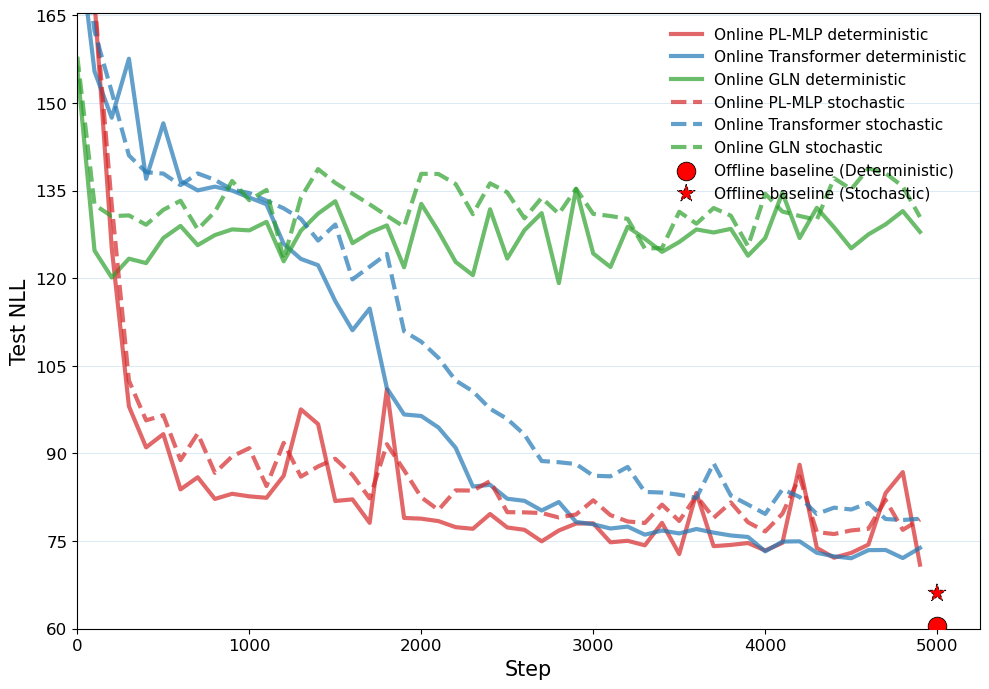

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale


files = [
    ".././results/onlineMLP_autoreg_deterministic.npz",
    ".././results/onlineTransformer_autoreg_deterministic.npz",
    ".././results/onlineGLN_autoreg_deterministic.npz",
    ".././results/onlineMLP_autoreg_stochastic.npz",
    ".././results/onlineTransformer_autoreg_stochastic.npz",
    ".././results/onlineGLN_autoreg_stochastic.npz",
]
labels = [
    "Online PL-MLP deterministic",
    "Online Transformer deterministic",
    "Online GLN deterministic",
    "Online PL-MLP stochastic",
    "Online Transformer stochastic",
    "Online GLN stochastic",
]

# colors in the SAME order as files/labels above
colors = [
    "tab:red",  # MLP deterministic
    "tab:blue",    # Transformer deterministic
    "tab:green",    # GLN deterministic
    "tab:red",     # MLP stochastic
    "tab:blue",   # Transformer stochastic
    "tab:green",    # GLN stochastic
]

linestyles = [
    "-",   # MLP deterministic (solid)
    "-",   # Transformer deterministic (solid)
    "-",   # GLN deterministic
    "--",  # MLP stochastic (dashed)
    "--",  # Transformer stochastic (dashed)
    "--", # GLN stochastic
]
y0 = 165.0
k = 10.0
ymin, ymax = 60, 200

def forward(y):
    y = np.asarray(y, dtype=float)
    out = y.copy()
    m = y > y0
    out[m] = y0 + (y[m] - y0) / k
    return out

def inverse(yt):
    yt = np.asarray(yt, dtype=float)
    out = yt.copy()
    m = yt > y0
    out[m] = y0 + (yt[m] - y0) * k
    return out

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_yscale(FuncScale(ax, (forward, inverse)))

for f, lab, c, ls in zip(files, labels, colors,linestyles):
    d = np.load(f)
    x = d["step"]
    y = d["test_nll"]
    ax.plot(x, y, label=lab, color=c, linestyle=ls, linewidth=3,alpha = 0.7)

ax.scatter(
    [5000], [forward(np.array([60.518]))[0]],
    marker='o', s=180, c='red',
    edgecolors='k', linewidths=0.6, zorder=3,
    label='Offline baseline (Deterministic)'
)
star = ax.scatter(
    [5000], [forward(np.array([66.09]))[0]],
    marker='*', s=180, c='red',
    edgecolors='k', linewidths=0.6, zorder=3,
    label='Offline baseline (Stochastic)'
)
star.set_linestyle('--')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels([str(t) for t in ax.get_xticks()])

for yline in [60, 75, 90, 105, 120, 135, 150, 165, 180, 195]:
    ax.axhline(yline, linewidth=0.6, alpha=0.18, zorder=0)

ax.set_yticks([60, 75, 90, 105,120,135,150,165,180,195])
ax.set_yticklabels([str(t) for t in ax.get_yticks()])
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.set_xlim(left=0)
ax.set_ylim(ymin, forward(np.array([ymax]))[0] if ymax is not None else None)
ax.set_xlabel("Step",fontsize = 15)
ax.set_ylabel("Test NLL",fontsize = 15)
ax.legend(loc="upper right", frameon=False,fontsize = 11)
plt.tight_layout()
plt.show()